In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-land-temperature')

import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry
import requests
import matplotlib.pyplot as plt
import datetime as dt
import math


#plt.style.use("seaborn-v0_8")

In [2]:
import math
def lsf(w, bt, e):
    '''Land Surface Temperature'''
    return bt / (
        (1 + (w * bt)) / (14380 * math.log(math.e))
        )

In [3]:
import geemap
import rasterio
import numpy
import geopandas as gpd
import pandas as pd


#Loading FAO Collection
dataset  = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

#filtering Rio de Janeiro
AOI = dataset.filter(ee.Filter.eq('ADM2_NAME', 'Rio De Janeiro'))


In [4]:
#Adding to map to visualize. 
Map = geemap.Map(center = (-23, -43.2), zoom = 10)
Map.addLayer(AOI, {}, 'Rio de Janeiro')

In [5]:
# Initial date of interest (inclusive).
i_date = '2025-01-01'

# Final date of interest (exclusive).
f_date = '2025-01-31'

# Selection of appropriate bands and dates for LST.

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection("MODIS/061/MYD11A1") 
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)


In [6]:
lst

In [7]:
#Stations

bangu = [-22.88028,	-43.46583] #lat, long
iraja = [-22.82694, -43.33694]
copa = [-22.98639,	-43.18944]
tijuca = [-22.93194, -43.22167]

p_bangu = ee.Geometry.Point(bangu[1], bangu[0])
p_iraja = ee.Geometry.Point(iraja[1], iraja[0])
p_copa = ee.Geometry.Point(copa[1], copa[0])
p_tijuca = ee.Geometry.Point(tijuca[1], tijuca[0])

In [8]:
Map.addLayer(p_bangu, {'color' :'red'}, 'Bangu')
Map.addLayer(p_iraja, {'color':'yellow'}, 'Irajá')
Map.addLayer(p_copa, {'color': 'blue'}, 'Copacabana')
Map.addLayer(p_tijuca, {'color':'green'}, 'Tijuca')

In [9]:
Map

Map(center=[-23, -43.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [10]:
scale = 5000 #scale in meters

#Get the time series
p_iraja_poi = lst.getRegion(p_iraja, scale).getInfo()
p_bangu_poi = lst.getRegion(p_bangu, scale).getInfo()
p_copa_poi = lst.getRegion(p_copa, scale).getInfo()
p_tijuca_poi = lst.getRegion(p_tijuca, scale).getInfo()


In [11]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def t_modis_to_celcius(t_modis):
    '''Converts the Modis Temperature LST Units to °C.'''

    return 0.02*t_modis - 273.15



In [12]:
# Transform the array to a dataframe and then convert the temperature from Kelvin to Celcius.

df_iraja = ee_array_to_df(p_iraja_poi, ['LST_Day_1km'])
df_iraja['LST_Day_1km'] = df_iraja['LST_Day_1km'].apply(t_modis_to_celcius)

df_bangu = ee_array_to_df(p_bangu_poi, ['LST_Day_1km'])
df_bangu['LST_Day_1km'] = df_bangu['LST_Day_1km'].apply(t_modis_to_celcius)

df_copa = ee_array_to_df(p_copa_poi, ['LST_Day_1km'])
df_copa['LST_Day_1km'] = df_copa['LST_Day_1km'].apply(t_modis_to_celcius)

df_tijuca = ee_array_to_df(p_tijuca_poi, ['LST_Day_1km'])
df_tijuca['LST_Day_1km'] = df_tijuca['LST_Day_1km'].apply(t_modis_to_celcius)

dfs = [df_iraja, df_bangu, df_copa, df_tijuca]

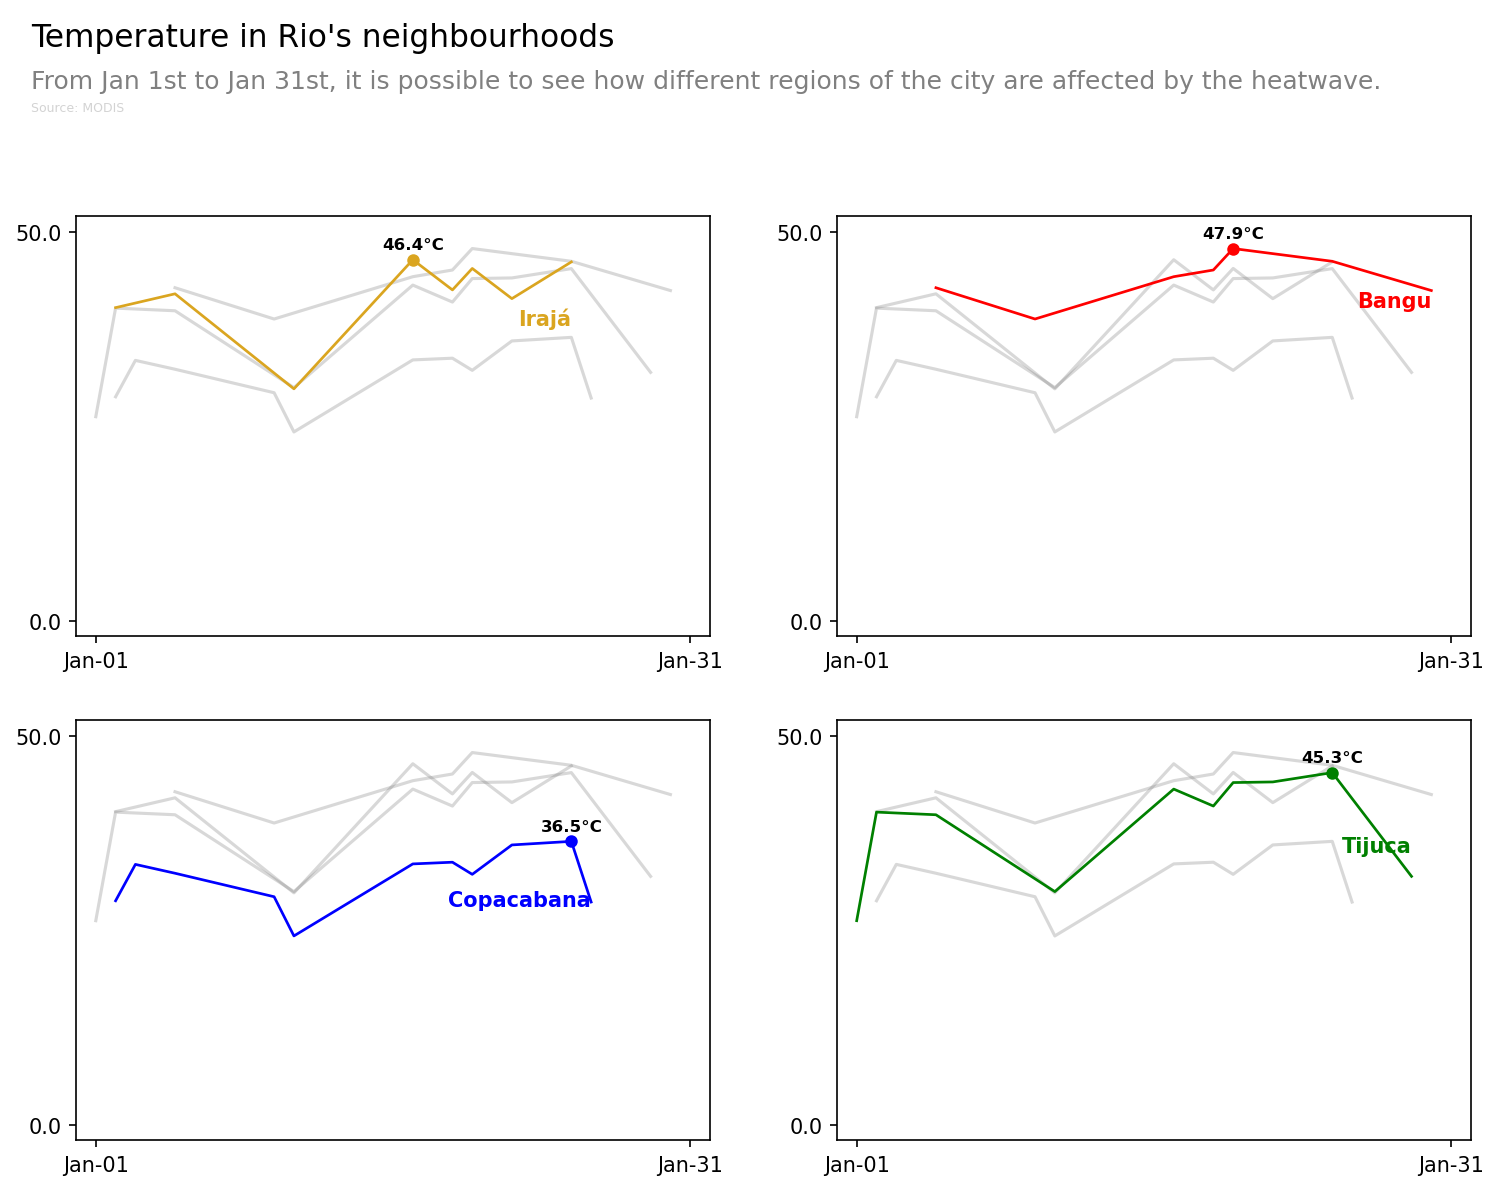

In [77]:
# annotations
from highlight_text import ax_text, fig_text

# custom fonts
from matplotlib import font_manager
from matplotlib.font_manager import FontProperties

# arrows
from matplotlib.patches import FancyArrowPatch

titles = ['Irajá', 'Bangu', 'Copacabana', 'Tijuca']
colors = ['goldenrod','red', 'blue', 'green']
y_adj = 1

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi = 150)
axes = axes.flatten()  # Flatten the 2x2 axes array for easier iteration

for i, target_df in enumerate(dfs):
    ax = axes[i]
    
    # Plot all DataFrames as gray lines (comparison)
    for j, df in enumerate(dfs):
        if i != j:  # Don't plot the target DataFrame as gray
            ax.plot(df['datetime'], df['LST_Day_1km'], color='gray', alpha=0.3)

    # Plot the target DataFrame with a distinct color (highlight)
    ax.plot(target_df['datetime'], target_df['LST_Day_1km'], color=colors[i], linewidth=1.3)  # Example: red, thicker line
    
    #ax.set_ylabel('Temperature (°C)')
    ax.grid(False)
    #ax.set_axis_off()
    ax.set_xlim(target_df['datetime'].min() - pd.Timedelta(days=1), target_df['datetime'].max() + pd.Timedelta(days = 1))
    ax.set_ylim(0, 50)
    ax.tick_params(axis='x', rotation=45)
    ax.text(
        target_df['datetime'].max(),  # Place text at the end of the x-axis
        target_df['LST_Day_1km'].mean() -1.5, # Adjust vertical position
        f'{titles[i]}',  # Use title as text
        va='top', ha='right',
        fontsize=10, fontweight='bold', #Use fontweight instead of a bold font variable
        color=colors[i]
    )
    # Customize X-axis ticks and labels
    first_date = dt.datetime(2025,1,1)
    last_date = dt.datetime(2025,1,31)
    ax.set_xticks([first_date, last_date])
    ax.set_xticklabels([first_date.strftime('%b-%d'), last_date.strftime('%b-%d')], rotation=0, ha='center')
    ax.set_xlim(first_date - pd.Timedelta(days=1), last_date + pd.Timedelta(days=1))

    # Customize Y-axis ticks and labels
    min_temp = 0
    max_temp = 50
    ax.set_yticks([min_temp, max_temp])
    ax.set_yticklabels([f'{min_temp:.1f}', f'{max_temp:.1f}'])
    ax.set_ylim(min_temp - 2, max_temp + 2) #adjust y limits to add padding

    max_temp_val = target_df['LST_Day_1km'].max()
    max_temp_date = target_df.loc[target_df['LST_Day_1km'].idxmax(), 'datetime']

    ax_text(
        x=max_temp_date,  # Place text at the x coordinate of the max temperature
        y=max_temp_val + 1,  # Place text slightly above the max temperature
        s=(f'{max_temp_val:.1f}°C'),
        va='bottom', ha='center',
        fontsize=8, fontweight='bold',
        color='black', ax=ax
    )

    ax.plot(max_temp_date, max_temp_val, 'o', color=colors[i], markersize=5) # Plotting a point where the max temp occurs

      


#Setting title and suptitle
title = f"""Temperature in Rio's neighbourhoods
<From Jan 1st to Jan 31st, it is possible to see how different regions of the city are affected by the heatwave.> 
<Source: MODIS>
"""

fig_text(
    0.1, 1,
    title,
    fontsize = 15, 
    ha = 'left', va = 'center',
    color = 'black',
    highlight_textprops=[
        {'color': 'grey', 'fontsize': 12},
        {'color': 'lightgrey', 'fontsize': 6}
   ],
   fig = fig
    
)
plt.savefig('tempRJ.png')

plt.show()


# Temperature Analysis

In [14]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": -22.9064,
	"longitude": -43.1822,
	"hourly": ["temperature_2m", "apparent_temperature"],
	"past_days": 31,
	"forecast_days": 1
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature

hourly_dataframe = pd.DataFrame(data = hourly_data)
print(hourly_dataframe)


Coordinates -22.75°N -43.0°E
Elevation 12.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                         date  temperature_2m  apparent_temperature
0   2025-01-31 00:00:00+00:00       27.825998             33.876556
1   2025-01-31 01:00:00+00:00       27.375999             33.166546
2   2025-01-31 02:00:00+00:00       27.025999             32.727554
3   2025-01-31 03:00:00+00:00       26.726000             32.415531
4   2025-01-31 04:00:00+00:00       26.625999             32.399647
..                        ...             ...                   ...
763 2025-03-03 19:00:00+00:00       33.176003             35.520409
764 2025-03-03 20:00:00+00:00       32.326000             34.724884
765 2025-03-03 21:00:00+00:00       30.675999             33.654549
766 2025-03-03 22:00:00+00:00       29.025999             32.634369
767 2025-03-03 23:00:00+00:00       27.875999             31.838783

[768 rows x 3 columns]


Text(0.5, 1.0, 'Temperature in °C - Rio de Janeiro')

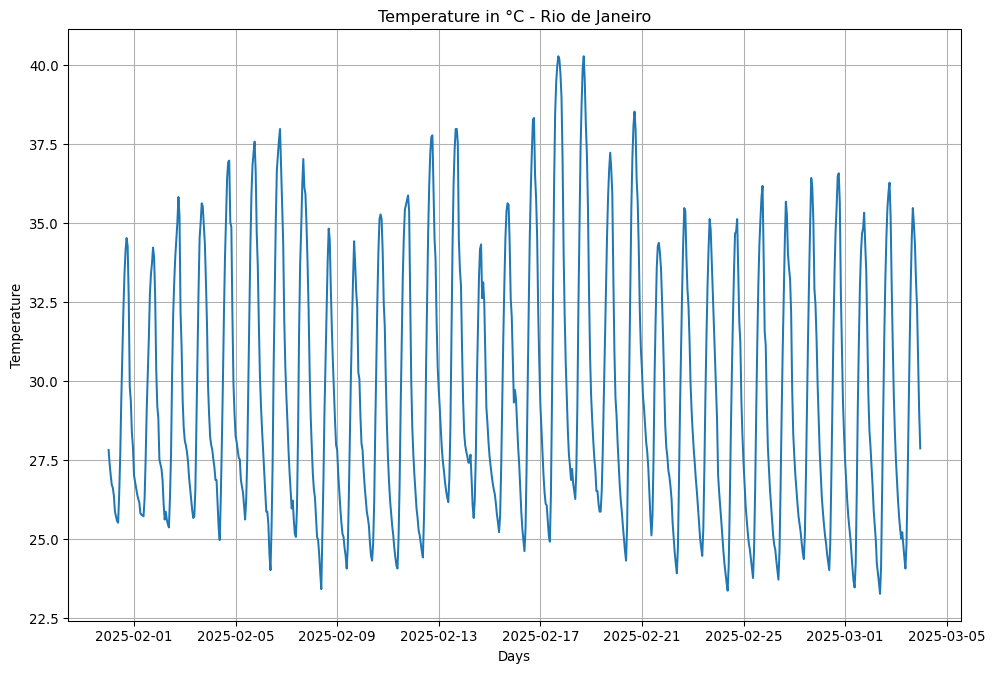

In [15]:
my_dpi=96
plt.figure(figsize=(12,8), dpi=my_dpi)

plt.plot( hourly_dataframe['date'], hourly_dataframe['temperature_2m'])
#plt.plot(hourly_dataframe['date'], hourly_dataframe['apparent_temperature'], 'red')
plt.grid()
plt.ylabel('Temperature')
plt.xlabel('Days')
plt.title('Temperature in °C - Rio de Janeiro')


In [16]:
hourly_dataframe.groupby('date').min()

,temperature_2m,apparent_temperature
date,,
2025-01-31 00:00:00+00:00,27.825998,33.876556
2025-01-31 01:00:00+00:00,27.375999,33.166546
2025-01-31 02:00:00+00:00,27.025999,32.727554
2025-01-31 03:00:00+00:00,26.726000,32.415531
2025-01-31 04:00:00+00:00,26.625999,32.399647
...,...,...
2025-03-03 19:00:00+00:00,33.176003,35.520409
2025-03-03 20:00:00+00:00,32.326000,34.724884
2025-03-03 21:00:00+00:00,30.675999,33.654549


In [17]:
hourly_dataframe.groupby('date').agg(
    {
        'temperature_2m': ['min','max']
        }
    )


temperature_2m           
                                     min        max
date                                               
2025-01-31 00:00:00+00:00      27.825998  27.825998
2025-01-31 01:00:00+00:00      27.375999  27.375999
2025-01-31 02:00:00+00:00      27.025999  27.025999
2025-01-31 03:00:00+00:00      26.726000  26.726000
2025-01-31 04:00:00+00:00      26.625999  26.625999
...                                  ...        ...
2025-03-03 19:00:00+00:00      33.176003  33.176003
2025-03-03 20:00:00+00:00      32.326000  32.326000
2025-03-03 21:00:00+00:00      30.675999  30.675999
2025-03-03 22:00:00+00:00      29.025999  29.025999
2025-03-03 23:00:00+00:00      27.875999  27.875999

[768 rows x 2 columns]

In [18]:
import numpy as np 

#Get the day, hour and temperature
hour = hourly_dataframe['date'].dt.hour
day  = hourly_dataframe['date'].dt.day
temp = hourly_dataframe['temperature_2m']

#Re-arrange temp values
temp = temp.values.reshape(24, len(day.unique()), order='F')

# The first + 1 increases the length
# The outer + 1 ensures days start at 1, and not at 0.
xgrid = np.arange(day.max() + 1) + 1

ygrid = np.arange(25) #Hour start at 0, length 2. 

fig, ax = plt.subplots()

ax.pcolormesh(xgrid, ygrid, temp)
ax.set_frame_on(False)

ValueError: cannot reshape array of size 768 into shape (24,29)